In [13]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
from tqdm import tqdm
import pandas as pd
import copy

In [14]:
class RestartBandits:

    def __init__(self,x):
        self.A=x
        self.P_0_matrix=np.array([[1-self.A,self.A,0,0,0],
                    [1-self.A,0,self.A,0,0],
                    [1-self.A,0,0,self.A,0],
                    [1-self.A,0,0,0,self.A],
                    [1-self.A,0,0,0,self.A]])
        self.P_1_matrix=np.array([[1,0,0,0,0],
                    [1,0,0,0,0],
                    [1,0,0,0,0],
                    [1,0,0,0,0],
                    [1,0,0,0,0]])
        self.action_space=[0,1]
        self.state_space=[0,1,2,3,4]
        self.reward_matrix=[[self.A**1,0],[self.A**2,0],[self.A**3,0],[self.A**4,0],[self.A**5,0]]
    def step(self,state,action):
        new_state=state
        if(action==1):
            new_state=np.random.choice(self.state_space,replace=True,p=self.P_1_matrix[state])
            reward=self.reward_matrix[state][1]
        else:
            new_state=np.random.choice(self.state_space,replace=True,p=self.P_0_matrix[state])
            reward=self.reward_matrix[state][0]
        return [new_state,reward]





In [15]:
def act(Q_values,epsilon,state,arm_index):
    decision=np.random.binomial(n=1,p=epsilon,size=1)
    if decision==1:
        action=random.choice([0,1])
    else:
        action=np.argmax(Q_values[int(arm_index/10)][state])
    return action

In [16]:
N=50
#50 circular and 50 restart bandits
M=10
epsilon=0.1
subsidy=0
arm_indexes=[i for i in range(N)]
gamma=0.99

In [17]:
def Q_value_update(Q_values,state,next_state,action,reward,arm_index,subsidy,alpha):
    arm_index=int(arm_index/10)
    if action==1:
        Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/10)
    else:
        Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+subsidy+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/10)

In [18]:
alternative_indexes=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]
Q_values=[]
j=-1
for i in range(N):
    if(i%10==0):
        j=j+1
        Q_values.append([[((j+5)/10.0)**1,0],[((j+5)/10.0)**2,0],[((j+5)/10.0)**3,0],[((j+5)/10.0)**4,0],[((j+5)/10.0)**5,0]])


In [19]:
rewards=[]
subsidies=[]
action_sums=[]
betas=[]
alphas=[]
epsilon=0.1
beta=0

In [20]:
for i in range(1,1000001):
  # top_M_indices=act(alternative_indexes,N,M,epsilon)
  action_sum=0
  reward_sum=0
  action_flag=0
  alpha=1/(1+(i/1000))
  if i%50==0:
    beta=1/(1+(i*np.log(i)/1000))
  j=-1
  for index in arm_indexes:
      if index%10==0:
        j=j+1
        restart_bandits=RestartBandits((j+5)/10.0)
      # action=np.argmax(Q_values[index][current_state[index]])
      action=act(Q_values,epsilon,current_state[index],index)

      action_sum+=action
      if action_flag==1:
        continue
      x=restart_bandits.step(current_state[index],action)
      new_state=x[0]
      reward=x[1]
      Q_value_update(Q_values,current_state[index],new_state,action,reward,index,subsidy,alpha)
      current_state[index]=new_state
      reward_sum+=reward
      if action_sum==M:
        action_flag=1

      #print(x)
  # print(i)
  #print(reward_sum)

  subsidy+=beta*(action_sum-M)
  subsidies.append(subsidy)
  # epsilon=epsilon*gamma
  # if epsilon<=0.01:
  #   epsilon=0.01
  rewards.append(reward_sum)
  action_sums.append(action_sum)
  betas.append(beta)
  alphas.append(alpha)








Text(0.5, 1.0, 'Subsidy vs Steps for Combined Example')

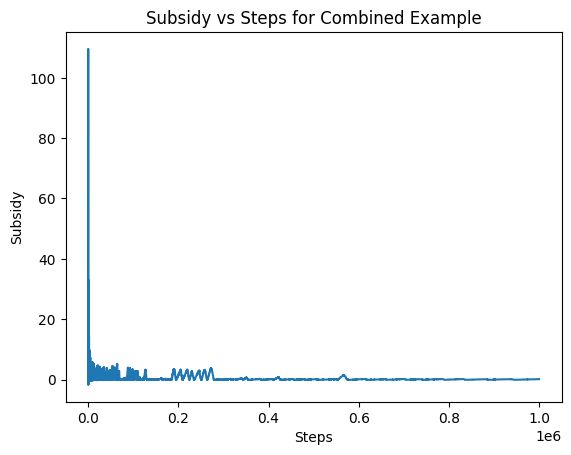

In [21]:
plt.plot(subsidies)
plt.xlabel('Steps')
plt.ylabel('Subsidy')
plt.title('Subsidy vs Steps for Combined Example')

In [22]:
df=pd.DataFrame(rewards)


Text(0.5, 1.0, ' Moving Average of number of arms activated for Combined Example ')

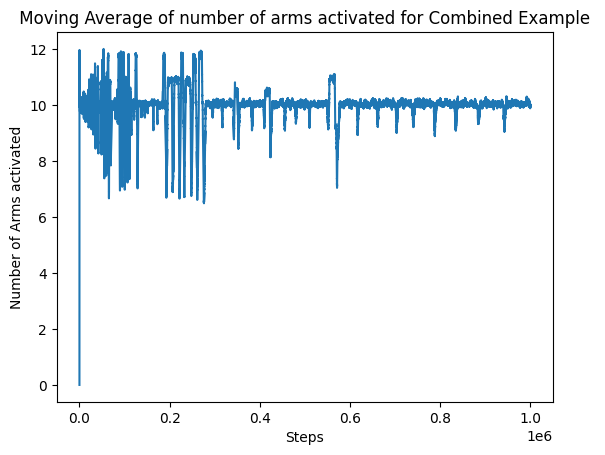

In [23]:
df['action_sums']=action_sums
plt.plot(df['action_sums'].rolling(1000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Number of Arms activated')
plt.title(' Moving Average of number of arms activated for Combined Example ')

Text(0.5, 1.0, ' Moving Average of reward for Combined Example ')

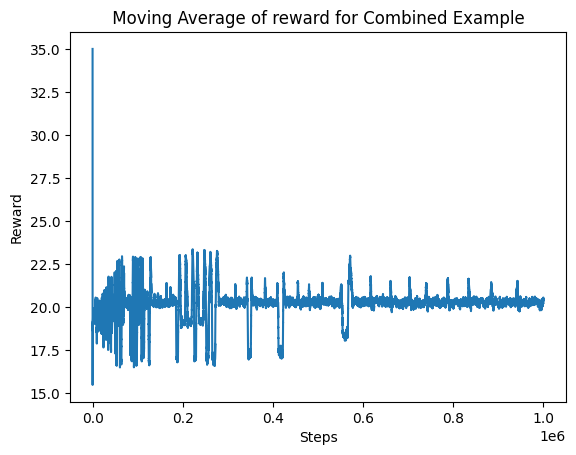

In [24]:
plt.plot(df[0].rolling(1000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title(' Moving Average of reward for Combined Example ')

In [27]:
whittle_indexes=[[-0.48892622121978974,
 -0.13002667414860714,
 0.07845132139051907,
 0.2468133262054437,
 0.7567025001124185],[-0.5999999995442491,
 -0.21220642312820912,
 0.06596513677544474,
 0.2448317271001214,
 0.3871150075437588],[-0.6999999971135857,
 -0.33791092169106024,
 -0.01988865746870765,
 0.2324268820604551,
 0.3637076056530988],[-0.7999999939285084,
 -0.5086695852261819,
 -0.198400950853426,
 0.0943789383042964,
 0.33831136151900687],[-0.8999999857150341,
 -0.7280899048807282,
 -0.5063880276153208,
 -0.26469859446651006,
 -0.02349460739783953]]

In [28]:
#using learnt indices
current_state=[0 for _ in range(N)]
reward_sums_alt_index=[]
reward_sums_whittle_index=[]
alternative_indexes=[0 for _ in range(N)]
for i in range(1,10001):
  reward_sum_alt_index=0
  reward_sum_whittle_index=0
  for index in arm_indexes:
    alternative_indexes[index]=Q_values[int(index/10)][current_state[index]][1]-Q_values[int(index/10)][current_state[index]][0]
  indices_to_pull = sorted(range(len(alternative_indexes)), key = lambda j: alternative_indexes[j])[-M:]
  j=-1
  for index in arm_indexes:
    if index%10==0:
      j=j+1
      restart_bandits=RestartBandits((j+5)/10.0)
    if index in indices_to_pull:
      x=restart_bandits.step(current_state[index],1)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward

    else:
      x=restart_bandits.step(current_state[index],0)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward

  reward_sums_alt_index.append(reward_sum_alt_index)


In [29]:
whittle_index_arms=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]
for i in range(1,10001):
  reward_sum_whittle_index=0
  g=-1
  for index in arm_indexes:
    if index%10==0:
       g=g+1
    whittle_index_arms[index]=whittle_indexes[g][current_state[index]]
  indices_to_pull = sorted(range(len(whittle_index_arms)), key = lambda j: whittle_index_arms[j])[-M:]
  # print(indices_to_pull)
  j=-1
  for index in arm_indexes:
    if index%10==0:
       j=j+1
       restart_bandits=RestartBandits((j+5)/10.0)
    if index in indices_to_pull:
        x=restart_bandits.step(current_state[index],1)
        new_state=x[0]
        reward=x[1]
        current_state[index]=new_state
        reward_sum_whittle_index+=reward


    else:
        x=restart_bandits.step(current_state[index],0)
        new_state=x[0]
        reward=x[1]
        current_state[index]=new_state
        reward_sum_whittle_index+=reward

  reward_sums_whittle_index.append(reward_sum_whittle_index)

Text(0.5, 1.0, ' Moving Average of reward for Combined Example ')

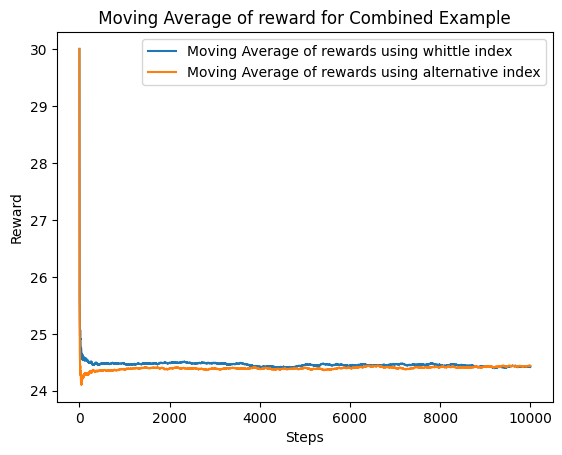

In [30]:
df_rewards=pd.DataFrame()

df_rewards['reward_whittle']=reward_sums_whittle_index
df_rewards['reward_alternate']=reward_sums_alt_index

plt.plot(df_rewards['reward_whittle'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using whittle index')
plt.plot(df_rewards['reward_alternate'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using alternative index')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.title(' Moving Average of reward for Combined Example ')